<a href="https://colab.research.google.com/github/katarinagresova/AgoBind/blob/main/notebooks/DNABERT_for_CLASH_1_1_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install -q -U git+https://github.com/katarinagresova/AgoBind

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 43.0 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 895 kB 42.0 MB/s 
     |████████████████████████████████| 6.5 MB 32.5 MB/s 


In [2]:
!pip install -q comet_ml
!pip install -q matplotlib

     |████████████████████████████████| 342 kB 3.4 MB/s 
     |████████████████████████████████| 551 kB 40.9 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 54 kB 1.9 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download data

In [4]:
!wget https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRBind/main/Datasets/train_set_1_1_CLASH2013_paper.tsv -P data
!wget https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRBind/main/Datasets/evaluation_set_1_1_CLASH2013_paper.tsv -P data

--2022-03-28 15:36:24--  https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRBind/main/Datasets/train_set_1_1_CLASH2013_paper.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2276853 (2.2M) [text/plain]
Saving to: ‘data/train_set_1_1_CLASH2013_paper.tsv’

train_set_1_1_CLASH 100%[===================>]   2.17M  --.-KB/s    in 0.06s   

2022-03-28 15:36:25 (35.9 MB/s) - ‘data/train_set_1_1_CLASH2013_paper.tsv’ saved [2276853/2276853]

--2022-03-28 15:36:25--  https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRBind/main/Datasets/evaluation_set_1_1_CLASH2013_paper.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.co

# Parameters

In [5]:
from agobind.models import get_dnabert

config = {
    "train_data" : "data/train_set_1_1_CLASH2013_paper.tsv",
    "test_data": "data/evaluation_set_1_1_CLASH2013_paper.tsv",
    "eval_dset_ratio" : 0.2, #Deducted from the train set
    "batch_size" : 64,
    "gradient_accumulation_steps":4,
    "eval_steps" : 100,
    "freeze":False ,
    "layers_to_unfreeze":None,
    "random_weights":True,
    "kmer_len" : 6,
    "stride" : 1,
    "early_stopping_patience" : 5, 
    "learning_rate" : 2e-4,
    "weight_decay":0.01,
    "backbone":get_dnabert, 
}

In [6]:
from transformers import TrainingArguments

args = TrainingArguments(output_dir="output_checkpoints",
                        learning_rate=config['learning_rate'],
                        weight_decay=config['weight_decay'], 
                        num_train_epochs=500, 
                        per_device_train_batch_size=config['batch_size'],
                        per_device_eval_batch_size=config['batch_size'],
                        do_train=True,
                        do_eval=True,
                        logging_steps=10000,
                        warmup_steps=5000, 
                        eval_steps=config['eval_steps'],
                        evaluation_strategy="steps",
                        logging_strategy="steps",
                        logging_first_step=True,
                        load_best_model_at_end=True,
                        save_steps=100, 
                        save_total_limit=5,
                        gradient_accumulation_steps=config['gradient_accumulation_steps'],
                        metric_for_best_model="eval_loss"
)

# Setup comet.ml

When Google Drive is mounted, it will use API KEY stored there. Prompt will pop-up otherway.

In [7]:
import comet_ml

comet_ml.init(project_name='dnabert_for_clash')

COMET INFO: Comet API key is valid


# Train model

In [8]:
from agobind.training import get_trained_model

model, tokenizer = config['backbone'](config) 
trained_model, encoded_samples_test = get_trained_model(config, args, model, tokenizer)

Downloading:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of the model checkpoint at armheb/DNA_bert_6 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at armheb/DNA_bert_6 and are n

model device cuda:0
reseting weights


You are adding a <class 'transformers.integrations.CometCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
CometCallback
TensorBoardCallback
EarlyStoppingCallback
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 24628
  Num Epochs = 500
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 4
  Total optimization steps = 48000
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: keras, tensorboard, torch, tensorflow. Metrics and hyperparameters can still be log

Dataset CLASH of length 30784 has valid size of 6156 that is ratio of  0.2


COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/katarinagresova/dnabert-for-clash/8c29108209a24cda9ac8843de9cffd08

Automatic Comet.ml online logging enabled
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: keras, tensorboard, torch, tensorflow. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/katarinagresova/dnabert-for-clash/8c

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc Pr
100,0.731500,0.690697,0.492528,0.659991,0.492528,1.000000,0.746264
200,0.731500,0.668935,0.537362,0.119357,0.955446,0.063654,0.740138
300,0.731500,0.548941,0.753411,0.702470,0.865700,0.591029,0.829080
400,0.731500,0.905539,0.579922,0.268251,0.944223,0.156332,0.758043
500,0.731500,0.619472,0.696394,0.756292,0.625404,0.956464,0.801656
600,0.731500,0.421077,0.824074,0.824956,0.808875,0.841689,0.864268
700,0.731500,0.439648,0.815465,0.799577,0.859636,0.747361,0.865714
800,0.731500,0.429088,0.829110,0.834747,0.796941,0.876319,0.867088
900,0.731500,0.449684,0.813678,0.830451,0.752478,0.926451,0.857577
1000,0.731500,0.437235,0.799220,0.822363,0.728732,0.943602,0.850055


***** Running Evaluation *****
  Num examples = 6156
  Batch size = 64
Saving model checkpoint to output_checkpoints/checkpoint-100
Configuration saved in output_checkpoints/checkpoint-100/config.json
Model weights saved in output_checkpoints/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6156
  Batch size = 64
Saving model checkpoint to output_checkpoints/checkpoint-200
Configuration saved in output_checkpoints/checkpoint-200/config.json
Model weights saved in output_checkpoints/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6156
  Batch size = 64
Saving model checkpoint to output_checkpoints/checkpoint-300
Configuration saved in output_checkpoints/checkpoint-300/config.json
Model weights saved in output_checkpoints/checkpoint-300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6156
  Batch size = 64
Saving model checkpoint to output_checkpoints/checkpoint-400
Configuration saved in output_checkpoint

# Final logging

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: keras, tensorboard, torch, tensorflow. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/katarinagresova/dnabert-for-clash/2e6ac5b82047473da1598de63637c1d8

100%|██████████| 500/500 [08:13<00:00,  1.01it/s]


F1 score is 0.8337444499259989
Computing precision-recall curve


COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/katarinagresova/dnabert-for-clash/2e6ac5b82047473da1598de63637c1d8
COMET INFO:   Metrics:
COMET INFO:     test F1 score : 0.8337444499259989
COMET INFO:   Others:
COMET INFO:     Name : CLASH2013_paper:6:1:freeze=False:LR=0.0002:WD=0.01:BS=64:rand_weights=True:
COMET INFO:   Parameters:
COMET INFO:     backbone                    : <function get_dnabert at 0x7f87bcef97a0>
COMET INFO:     batch_size                  : 64
COMET INFO:     early_stopping_patience     : 5
COMET INFO:     eval_dset_ratio             : 0.2
COMET INFO:     eval_steps                  : 100
COMET INFO:     freeze                      : False
COMET INFO:     gradient_accumulation_steps : 4
COMET INFO:     kmer_len                    : 6
COMET INFO:  

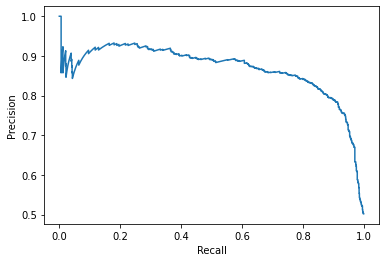

In [9]:
from agobind.eval import get_f1_score, compute_pr_curve, get_probs_and_labels

current_experiment = comet_ml.get_global_experiment()
afterlog_experiment = comet_ml.ExistingExperiment(previous_experiment=current_experiment.get_key())

name = f"{'CLASH2013_paper'}:{config['kmer_len']}:{config['stride']}:freeze={config['freeze']}:LR={config['learning_rate']}:WD={config['weight_decay']}:BS={config['batch_size']}:rand_weights={config['random_weights']}:"
afterlog_experiment.set_name(name)

probs, labels = get_probs_and_labels(config['test_data'], encoded_samples_test, trained_model)
f1_score_test = get_f1_score(probs, labels)
recall, precision = compute_pr_curve(probs, labels)

afterlog_experiment.log_parameters(config)
afterlog_experiment.log_metric("test F1 score", f1_score_test)
afterlog_experiment.log_curve(f"pr-curve", recall, precision)
# TODO: find path to the best model and log it
afterlog_experiment.log_model("DNABERT_CLASH", "./output_checkpoints/checkpoint-900")

afterlog_experiment.end()

In [10]:
!zip /content/dnabert_for_clash_1_1.zip output_checkpoints/checkpoint-900/

  adding: output_checkpoints/checkpoint-900/ (stored 0%)
